In [1]:
import torch 
from Ford_dataset import SatGrdDatasetFord, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds
from torch.utils.data import DataLoader

device = 'cpu'

logs_start = 2; logs_end = 3
range_lat = 20; range_lot=20; rotation_range =20; #meters, meters, degress
train_set  = SatGrdDatasetFord(logs=train_logs[logs_start:logs_end], logs_img_inds=train_logs_img_inds[logs_start:logs_end], mode='train')
val_set = SatGrdDatasetFord(logs=test_logs[logs_start:logs_end], logs_img_inds=test_logs_img_inds[logs_start:logs_end], mode='val')


Rs = {key:item.to(device) for key, item in train_set.Rs.items()}
Ts = {key:item.to(device) for key, item in train_set.Ts.items()}
Ks = {key:item.to(device) for key, item in train_set.Ks.items()}

In [2]:
class Config():
    device = 'cpu'

    orig_satmap_A = 512
    sat_map_A = 64

    vol_car_xyz = [128, 128, 4]#volume around car xyz shape  

    orig_img_H = 448 #original image height that is going as input into the neural network 
    orig_img_W = 896
    img_H = 448//8 #the output shape of the image encoder, later to be lifted to 3D 
    img_W = 896//8

    meter_per_pixel = 0.22 # this is fixed for the ford dataset meter per pixel of the original shape satellite map 512 * 512 

class Functions():
    def __init__(self, config) -> None:
        self.config = config

    def get_xyz_car(self):
        '''space around the ego vehicle shape (x,y,z), default (128,128,4)
        x:front [-56.3, 56.3] 
        y:left  [-56.3, 56.3]
        z:down  [-4.3, 3.7]
        '''

        x = (torch.arange(self.config.vol_car_xyz[0], dtype=torch.float32) / (self.config.vol_car_xyz[0] -1)) - 0.5
        x = - x * self.config.orig_satmap_A * self.config.meter_per_pixel
        x = x.unsqueeze(1)
        x = x.repeat(1, self.config.vol_car_xyz[0])

        y = (torch.arange(self.config.vol_car_xyz[1], dtype=torch.float32) / (self.config.vol_car_xyz[1] -1)) - 0.5
        y = y * self.config.orig_satmap_A * self.config.meter_per_pixel
        y = y.unsqueeze(0)
        y = y.repeat(self.config.vol_car_xyz[1], 1)

        xyz = torch.stack((x,y, torch.zeros_like(y)), dim=2).unsqueeze(2)
        xyz = xyz.repeat(1, 1, self.config.vol_car_xyz[2], 1)

        offset = -0.3 #for -0.3 we are at the level of the front camera 
        z = offset + ((torch.arange(self.config.vol_car_xyz[2], dtype=torch.float32) / (self.config.vol_car_xyz[2] -1)) -0.5) * 4

        xyz[:,:,:,2] = z[:] 

        # xyz indices
        x_id = torch.arange(self.config.vol_car_xyz[0], dtype=torch.int64).unsqueeze(1)
        x_id = x_id.repeat(1, self.config.vol_car_xyz[0]) 

        y_id = torch.arange(self.config.vol_car_xyz[1], dtype=torch.int64).unsqueeze(0)
        y_id = y_id.repeat(self.config.vol_car_xyz[1], 1)

        xy_id = torch.stack((x_id, y_id, torch.zeros_like(y_id)), dim =2).unsqueeze(2)
        
        xyz_id = xy_id.repeat(1,1,self.config.vol_car_xyz[2],1)
        xyz_id[:,:,:, 2] = torch.arange(self.config.vol_car_xyz[2], dtype=torch.int64)


        return xyz.contiguous(), xyz_id.contiguous()

    
    def render_xyz(self, R, T, K, xyz, xyz_ids):
        '''
        uvs shape [2, n]
        gather_ids shape [n], used for image of shape [C,H,W]
        scatter_ids shape [n] used for volume of shape [C,H,W,Z]  
        '''
        K = K.clone()
        K[0] = K[0] * (self.config.img_W / self.config.orig_img_W)
        K[1] = K[1] * (self.config.img_H /self.config.orig_img_H)

        # R, T is from camera to body 
        xyz_cam = (R.T @ xyz.view(-1,3).T - T.unsqueeze(1))
        uvs = K @ xyz_cam
        uvs[0] = uvs[0]/ uvs[2]
        uvs[1] = uvs[1]/ uvs[2]

        bf = (uvs[0, :] >= 0) & (uvs[1, :] >= 0) & (uvs[0, :] < self.config.img_W-1) & (uvs[1, :]<self.config.img_H-1) & (uvs[2, :] > 0.1)

        uvs = torch.round(uvs[:, bf]).type(torch.int64)
        xyz_ids_filtered = xyz_ids.view(-1, 3).T[:, bf]

        #v = x height u = y width in a matrix (v,u), uvs[0] -> u,y, uvs[1] -> v,x, ids = y + x * y_size
        gather_ids = uvs[0] + self.config.img_W * uvs[1]
        # ids = z + y * z_size + x * y_size * z_size
        scatter_ids = xyz_ids_filtered[2] + xyz_ids_filtered[1] * self.config.vol_car_xyz[2] + xyz_ids_filtered[0] * self.config.vol_car_xyz[1] * self.config.vol_car_xyz[2]

        return uvs[:2], gather_ids, scatter_ids
    
        
    

torch.Size([128, 128, 4, 3])
torch.Size([14809]) torch.Size([14809])


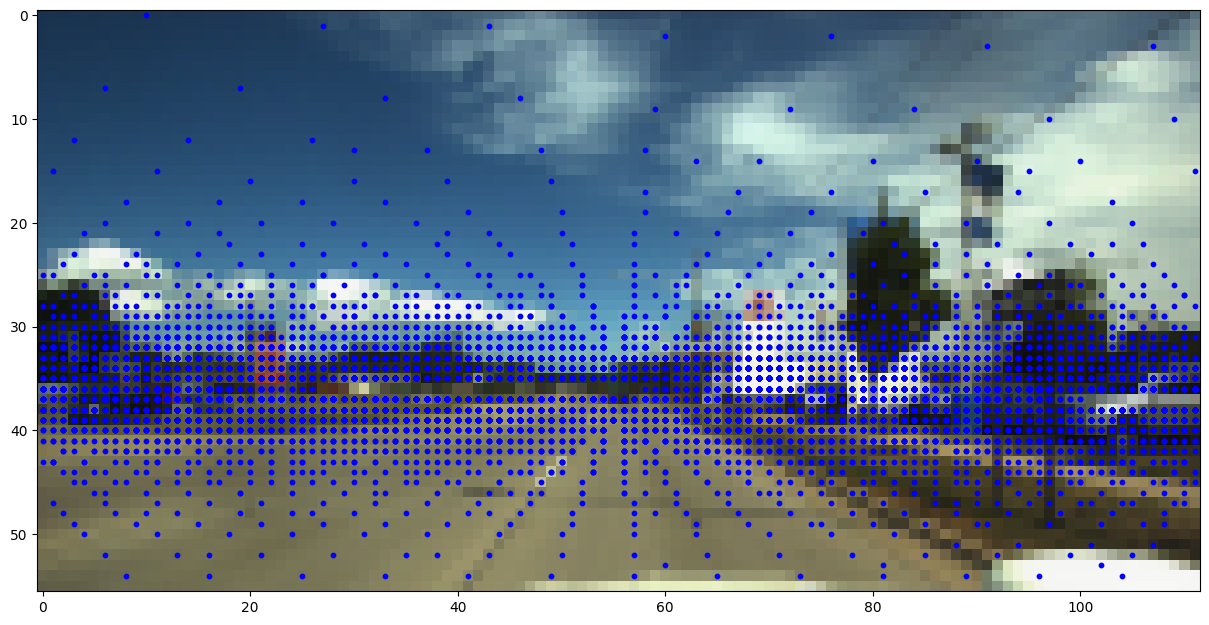

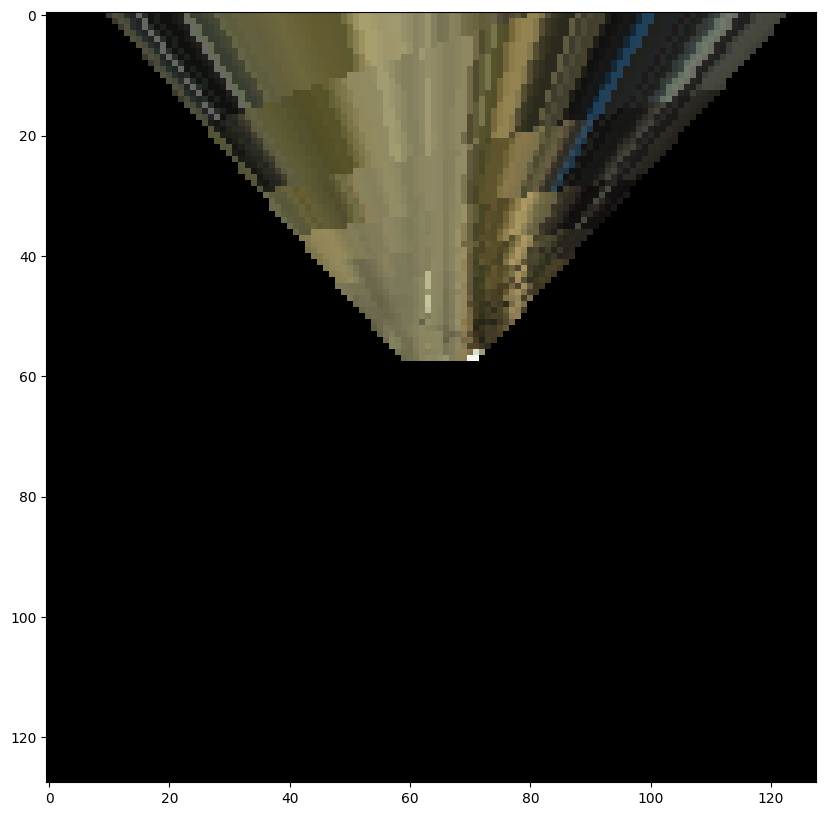

In [4]:
from matplotlib import pyplot as plt 
from torch.nn.functional import avg_pool2d
idx = 100
sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_norot_notran, mask_dt_xy, dt_xy = val_set[idx]

camera = 'FL'

config = Config()
functions = Functions(config)
xyz, xyz_ids = functions.get_xyz_car()
# xyz = xyz[:10,15:25,-1:, :]; xyz_ids = xyz_ids[:10,15:25, -1:, :]; xyz = xyz.contiguous(); xyz_ids = xyz_ids.contiguous()


print(xyz.shape)
uvs, gather_ids, scatter_ids = functions.render_xyz(Rs[camera], Ts[camera], Ks[camera], xyz, xyz_ids)


print(gather_ids.shape, scatter_ids.shape)

img = avg_pool2d(grd_imgs[0], 8) 

# img.view(3, -1)[:, gather_ids] = 1
plt.figure(figsize=(15,15))
plt.imshow(img.permute([1,2,0]))
plt.scatter(uvs[0, :], uvs[1, :], s=10, color=(0,0,1))
plt.show()

volume = torch.zeros((3, *config.vol_car_xyz), dtype=torch.float32)
volume.view(3, -1)[:, scatter_ids] = img.view(3, -1)[:, gather_ids] #[3,scatter_ids[xi,yi,zi]] = [3,gather_ids[hi,wi]] 
plt.figure(figsize=(10,10))
plt.imshow(volume.permute(1,2,3,0)[:,:,-1, :])
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.0].


tensor(39.) tensor(0.)


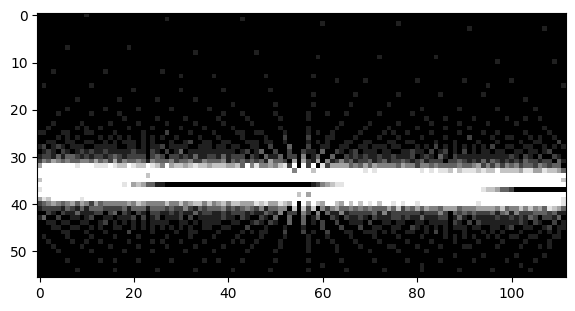

: 

In [5]:
img1 = torch.nn.Parameter(img.clone(), requires_grad=True)
img2 = torch.nn.Parameter(img.clone(), requires_grad=True)

volume = torch.zeros((3, *config.vol_car_xyz), dtype=torch.float32)
volume.view(3, -1)[:, scatter_ids] = img1.view(3, -1)[:, gather_ids] 
# volume.view(3, -1)[:, scatter_ids[:10000]] = img2.view(3, -1)[:, gather_ids[:10000]] 
loss = volume.sum()
loss.backward()


plt.figure(figsize=(15,15))
img_grad1 = img1.grad.permute([1,2,0])
print(img_grad1.max(), img_grad1.min())
img_grad1 = img_grad1/img_grad1.max() * 5
plt.subplot(1,2,1)
plt.imshow(img_grad1)


# img_grad2 = img2.grad.permute([1,2,0])
# print(img_grad2.max(), img_grad2.min())
# img_grad2 = img_grad2/img_grad2.max() * 5
# plt.subplot(1,2,2)
# plt.imshow(img_grad2)
# plt.show()
